# A notebook for descriptive statistics about the different methods.

Purpose of this notebook is to find the distribution for respective post-processing method, so that we can simulate different ratios, and have a benchmark curve, instead of a flat curve.


In [308]:
# set fcs
fcs =  [round(i*0.04,2) for i in range(20)]
# Note NEED TO CHANGE TRIQLER RESULTS DIRECTORY BELOW TO READ IN FILES 

In [309]:
fcs

[0.0,
 0.04,
 0.08,
 0.12,
 0.16,
 0.2,
 0.24,
 0.28,
 0.32,
 0.36,
 0.4,
 0.44,
 0.48,
 0.52,
 0.56,
 0.6,
 0.64,
 0.68,
 0.72,
 0.76]

In [310]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [311]:


import pandas as pd
import numpy as np

from scipy import stats

import os 

os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")

from q_value import qvalues
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run")



# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]
def decoy_mapper(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False
    
def read_in_and_filter(filename, m_score_treshold = 0.01):  
    print(filename)
    df = pd.read_csv(filename, sep = "\t")
    df = df[df.decoy != 1]
    df = df[df.m_score < m_score_treshold] # filter away crap, so all values should be good... we take average of top3 here
    print(str(len(df)) + " significantly identified peptides at " + str(m_score_treshold) + " FDR-treshold.")
    print("")
    df["experiment_id"] = df["filename"].map(experiment_id_mapper)
    df["sample_id"] = df["filename"].map(sample_id_mapper)
    sample_id = df.sample_id.unique()[0]
    experiment_id = df.experiment_id.unique()[0]     
    def top3(df):
        df = (df.groupby('ProteinName')['Intensity'].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan)
                  .reset_index())
        #print(df.isna().sum())
        return df
    df_reduced = df[["ProteinName", "Intensity"]]
    df_protein = top3(df_reduced)
    df = df_protein
    df["specie"] = df.ProteinName.map(specie_mapper)
    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    df = df.set_index(["specie", "ProteinName"])
    df = pd.DataFrame(df.values, columns = midx, index = df.index)
    
    return df



# highest scoring vs top highest intenstiy peptide?
# We take top3 intensity because we filter away so much with m_score < 0.01, all values should be good.

dfs = []
for file in os.listdir():
    if file[-10:] == "dscore.csv":
        dfs.append(read_in_and_filter(file, m_score_treshold=0.01))
        #print(len(df_part))
        #df = pd.concat([df, df_part],axis = 1)        
df = pd.concat(dfs, axis = 1)

df["decoy"] = df.index.get_level_values("ProteinName").map(decoy_mapper) 
df.decoy.sum()

A = df[df.iloc[:, df.columns.get_level_values("sample_id") == "1"].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == "1"]
#A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == "2"].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == "2"]
#B = np.log2(B)

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]





import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))

A.name = "1"
B.name = "2"

df_final = pd.concat([A, B, p_vals], axis = 1)
df_final["log2(A,B)"] = df_final["1"] - df_final["2"]

def pq_data(df_final, fc_treshold):
    # two-side treshold because triqler uses two side treshold.
    df_final_fc_gt = (df_final[df_final["log2(A,B)"] > fc_treshold])
    df_final_fc_lt = (df_final[df_final["log2(A,B)"] < -fc_treshold])
    df_final_fc = pd.concat([df_final_fc_gt, df_final_fc_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (df_final_fc["q"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# test
#pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = 0.2)
#pq_data(df_final[df_final.index.get_level_values("specie") == "YEAS8"], fc_treshold = 0.2)
#pq_data(df_final[df_final.index.get_level_values("specie") == "ECOLI"], fc_treshold = 0.2)


import matplotlib.pyplot as plt

specie = "HUMAN"

def plot_pq(df_final, specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    for i in range(10):
        fc =i*0.2
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        if i == 0:
            y_lim = df.max()[0]
        axs[row, col].plot(df.index, df.DE)
        axs[row, col].set_ylim([0, y_lim])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col += 1
        if col == 5:
            row +=1
            col = 0
    plt.suptitle("OSW top3 " + specie)
    plt.show()





osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML_with_dscore.csv
20494 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML_with_dscore.csv
22787 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML_with_dscore.csv
20747 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML_with_dscore.csv
22792 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML_with_dscore.csv
21445 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.mzML_with_dscore.csv
21016 significantly identified peptides at 0.01 F

/home/ptruong/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/ptruong/git/dia_sum/scripts/PXD002952/q_value.py:21: RuntimeWarning: invalid value encountered in less_equal
  Wls = np.array([n-np.argmax(p>=l) for l in lambdas])
/home/ptruong/git/dia_sum/scripts/PXD002952/q_value.py:28: RuntimeWarning: invalid value encountered in less_equal
  WlsBoot =np.array([n-np.argmax(pBoot>=l) for l in lambdas])


In [312]:

import time
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq = df_triq[df_triq.q_value < q_val]
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec]).T, index = fc_tresh, columns = ["HUMAN", "YEAST", "ECOLI"])
    return df

def map_decoy(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI"])
        res.append(df_res)
    return res

res = get_DE_for_fcs( fcs = fcs)



def msstats_pq_data(ms, fc):
    # ms = pd.read_csv("msstats.csv")
    ms_gt = ms[ms.log2FC > fc]
    ms_lt = ms[ms.log2FC < -fc]
    ms_fc = pd.concat([ms_gt, ms_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (ms_fc["adj.pvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# MSSTATS
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msstats_results")

ms = pd.read_csv("msstats_output_filtered.csv")
ms["specie"] = ms.Protein.map(specie_mapper)

ms[ms.specie == "YEAS8"]

#Rewrite this to function subplot
def plot_pq_specie(specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = [round(i*0.2,2) for i in range(9)] + [0.68]
    fcs.sort()
    for i in range(10):
        fc = fcs[i]
        res[i][specie].plot(ax = axs[row,col]) #triqler data plot
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


#os.chdir("/home/ptruong/git/MSqRobSum/inst/extdata")
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msrobsum_results")

msqrob = pd.read_csv("msqrobsum_result.csv", sep = "\t")
msqrob["specie"] = msqrob.proteins.map(specie_mapper)

msqrob

def msqrob_pq_data(msqrob, fc):
    msqrob_gt = msqrob[msqrob.logFC > fc]
    msqrob_lt = msqrob[msqrob.logFC < -fc]
    msqrob_fc = pd.concat([msqrob_gt, msqrob_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (msqrob_fc["qvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

msqrob_pq_data(msqrob, fc = 0.2)

DE
0.000     0
0.001   856
0.002   955
0.003  1006
0.004  1048
...     ...
0.096  1486
0.097  1487
0.098  1489
0.099  1489
0.100  1489

[101 rows x 1 columns]

In [313]:
res[0]

HUMAN  YEAST  ECOLI
0.000      0      0      0
0.001    956    415    474
0.002   1027    431    492
0.003   1074    449    508
0.004   1103    458    525
...      ...    ...    ...
0.096   1676    702    716
0.097   1676    702    716
0.098   1676    702    716
0.099   1676    702    716
0.100   1676    702    716

[101 rows x 3 columns]

In [314]:

#Rewrite this to function subplot
def plot_pq_specie(specie, fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            res[i].sum(axis=1).plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final, fc_treshold = fc)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            res[i][specie].plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()



#Rewrite this to function subplot
def plot_pq_specie_FP(specie, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        if specie == "all":
            df = pq_data(df_final, fc_treshold = fc)
            df_triq = res[i].sum(axis=1)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_triq = res[i][specie]
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)

        # False positives
        df_FP = pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc)
        df_triq_FP = res[i]["HUMAN"]
        df_ms_FP = msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc)
        df_msqrob_FP = msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc)
        """
        if fc >= 1.0:
            df_FP_yeast = pq_data(df_final[df_final.index.get_level_values("specie") == "YEAS8"], fc_treshold = fc)
            df_triq_FP_yeast = res[i]["YEAS8"]
            df_ms_FP_yeast = msstats_pq_data(ms[ms.specie == "YEAS8"], fc = fc)
            df_msqrob_FP_yeast = msqrob_pq_data(msqrob[msqrob.specie == "YEAS8"], fc = fc)
            
            df_FP += df_FP_yeast
            df_triq_FP += df_triq_FP_yeast
            df_ms_FP += df_ms_FP_yeast
            df_msqrob_FP += df_msqrob_FP_yeast
        """ 
        df_triq.plot(ax = axs[row,col], style = "b") #triqler data plot
        axs[row, col].plot(df.index, df.DE, "k") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob
        
        # Plot False positives
        #res[i]["HUMAN"].plot(ax = axs[row,col], style="b--") #triqler data plot
        df_triq_FP.plot(ax = axs[row, col], style="b--")
        axs[row, col].plot(df.index, df_FP.DE, "k--") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms_FP.DE, "g--") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob_FP.DE, "r--") # plot msqrob
        

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob",
                                      "Triqler FP", "OSW Top3 FP", "msStats FP", "mSqRob FP" ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


#FP ratio
def plot_ratio_FP_DE(specie, fcs):
    fig, axs = plt.subplots(4, 5,figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final, fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i].sum(axis=1))
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms, fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob, fc = fc))        
        else:
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i][specie])
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms[ms.specie == specie], fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))        

        df_triq.plot(ax = axs[row, col], style = "b") # triqler data plot
        axs[row, col].plot(df.index, df.DE, "m") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")
        
        def abline(slope, intercept, row, col):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axs[row,col].get_xlim())
            y_vals = intercept + slope * x_vals
            axs[row,col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
        abline(1,0,row,col)
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()




#Rewrite this to function subplot
def plot_de_specie_xy(specie_x, specie_y, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        df_triq_x = res[i][specie_x]
        df_x = pq_data(df_final[df_final.index.get_level_values("specie") == specie_x], fc_treshold = fc)
        df_ms_x = msstats_pq_data(ms[ms.specie == specie_x], fc = fc)
        df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == specie_x], fc = fc)
        
        df_triq_y = res[i][specie_y]
        df_y = pq_data(df_final[df_final.index.get_level_values("specie") == specie_y], fc_treshold = fc)
        df_ms_y = msstats_pq_data(ms[ms.specie == specie_y], fc = fc)
        df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie == specie_y], fc = fc)
        
        #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
        #axs[row, col].plot(df.index, df.DE) # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        
        axs[row, col].plot(df_triq_x.values, df_triq_y.values)
        axs[row, col].plot(df_x.values, df_y.values)
        axs[row, col].plot(df_ms_x.values, df_ms_y.values)
        axs[row, col].plot(df_msqrob_x.values, df_msqrob_y.values)
        
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel(f"n - Differentially expressed {specie_x}")
        axs[row, col].set_ylabel(f"n - Differentially expressed {specie_y}")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins specie ratio ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


# PQ-plots

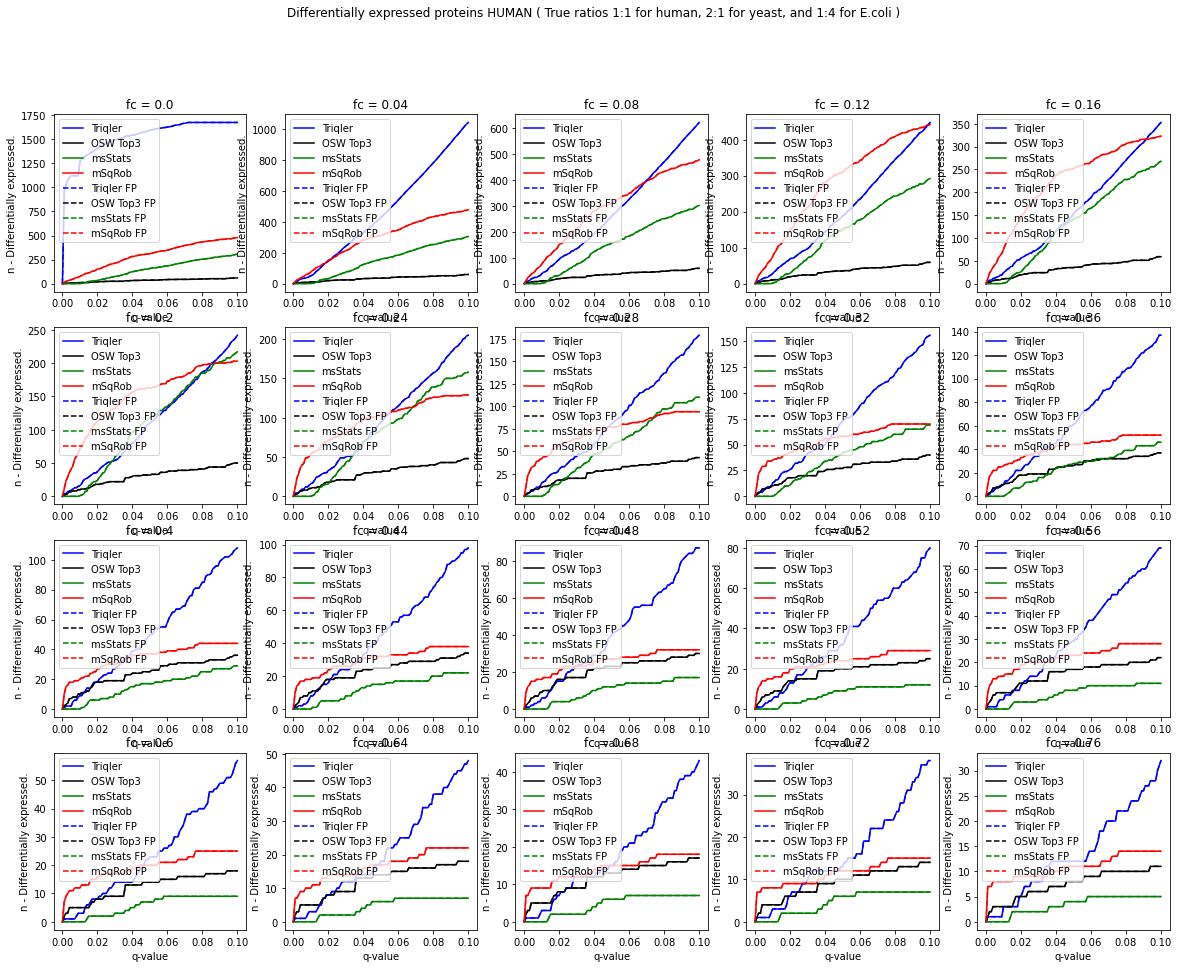

In [315]:
plot_pq_specie_FP(specie = "HUMAN", fcs = fcs)


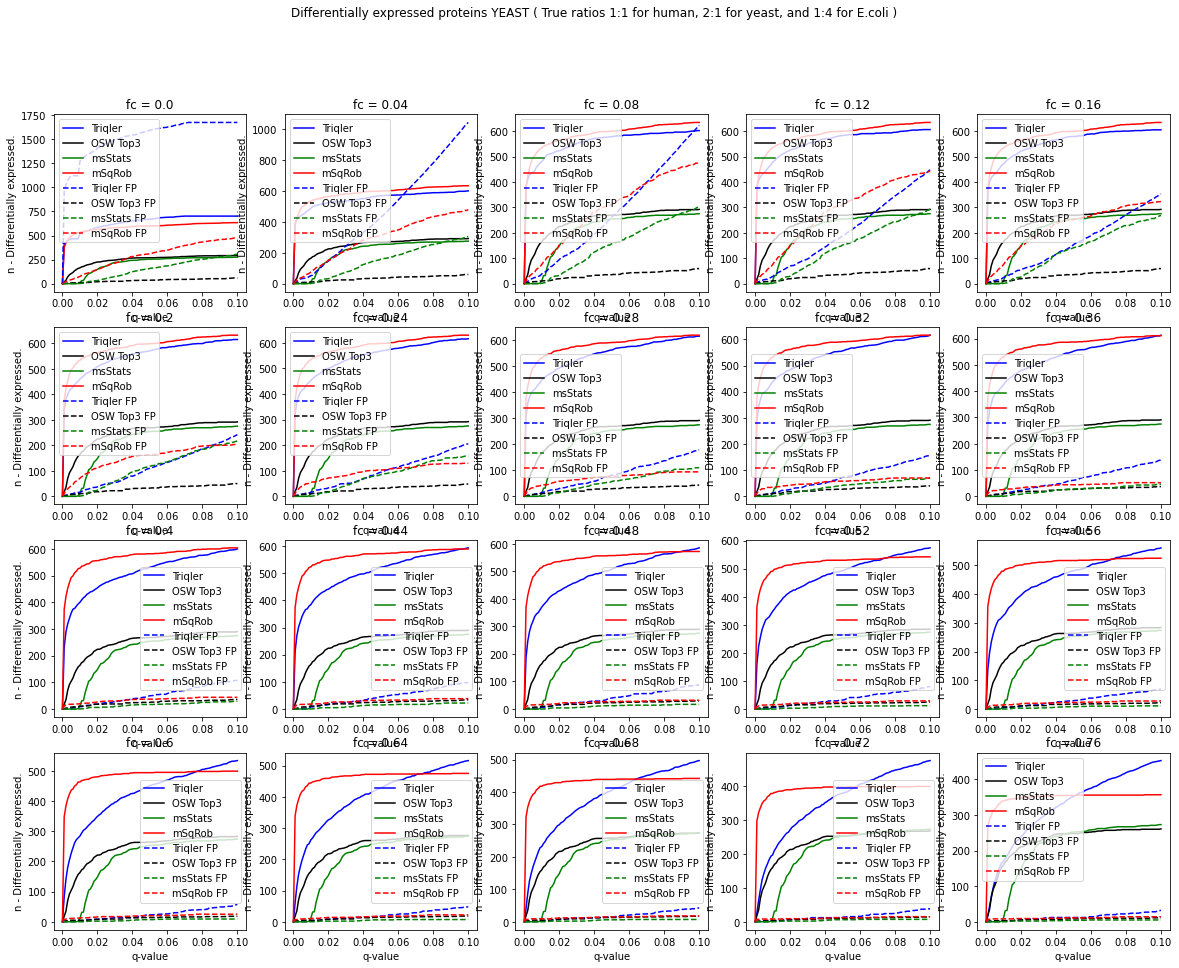

In [316]:
plot_pq_specie_FP(specie = "YEAST", fcs = fcs)


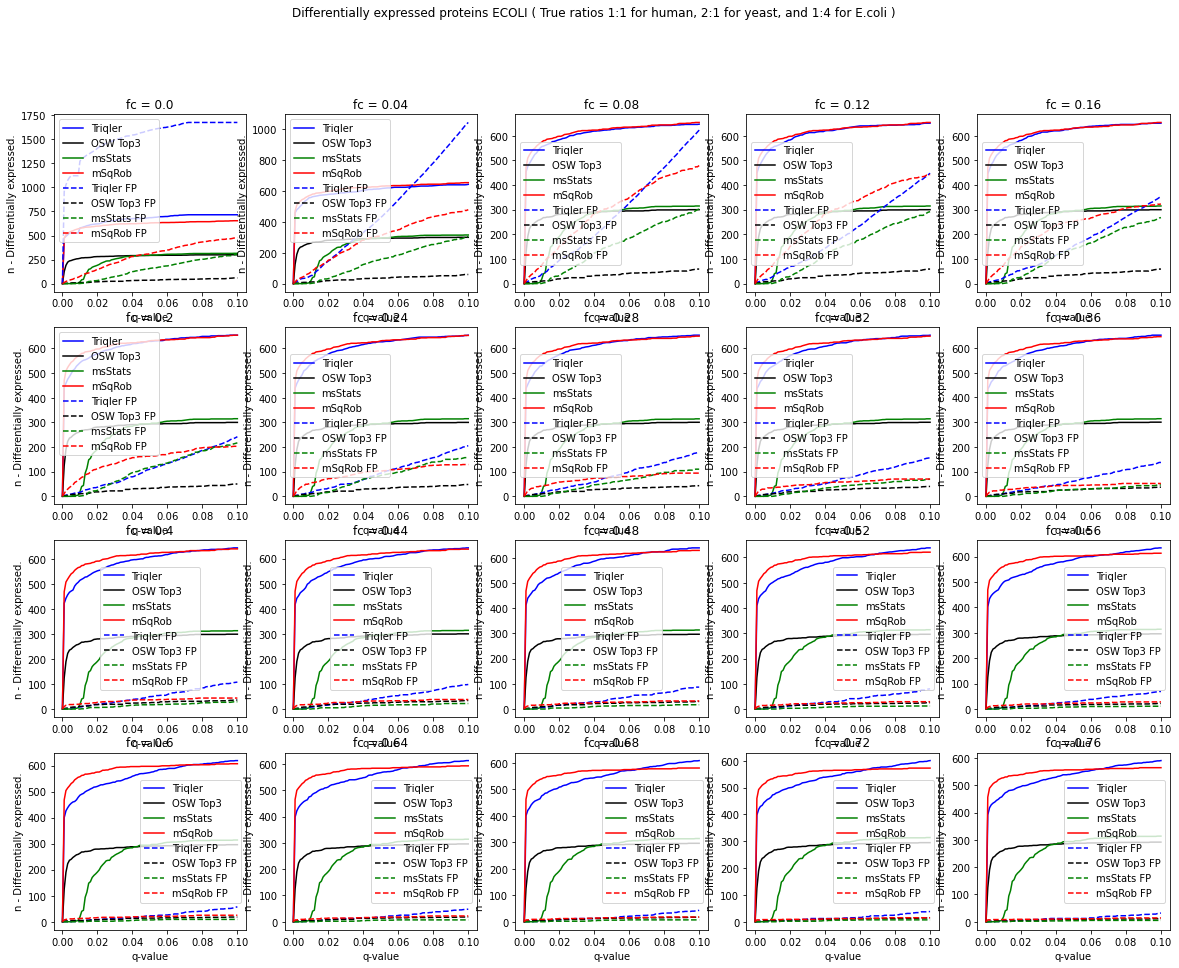

In [317]:
plot_pq_specie_FP(specie = "ECOLI", fcs = fcs)


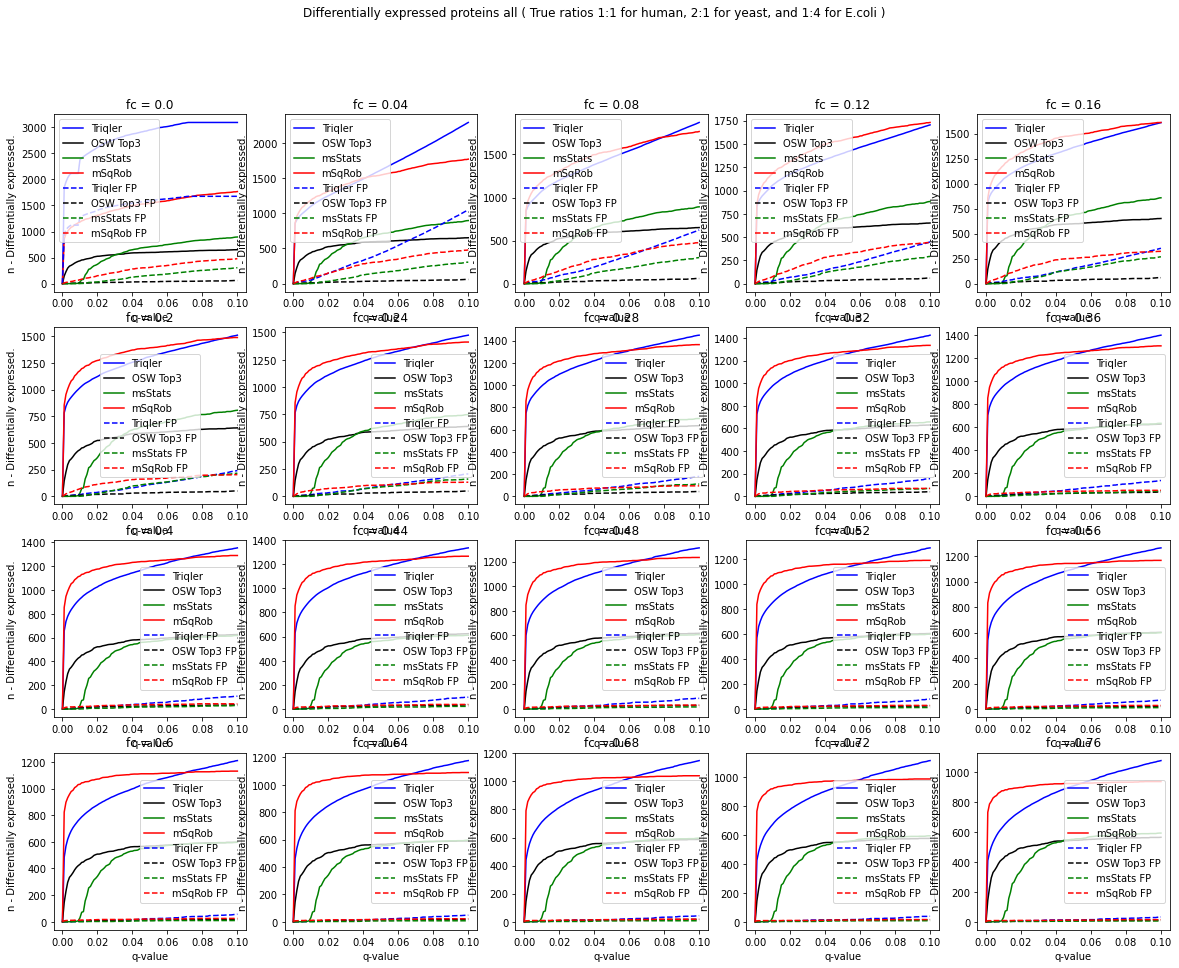

In [318]:
plot_pq_specie_FP(specie = "all", fcs = fcs)

# FP / DE ratio - Calibration plot

### FP is defined as DE-human proteins, DE is for DE for all species.

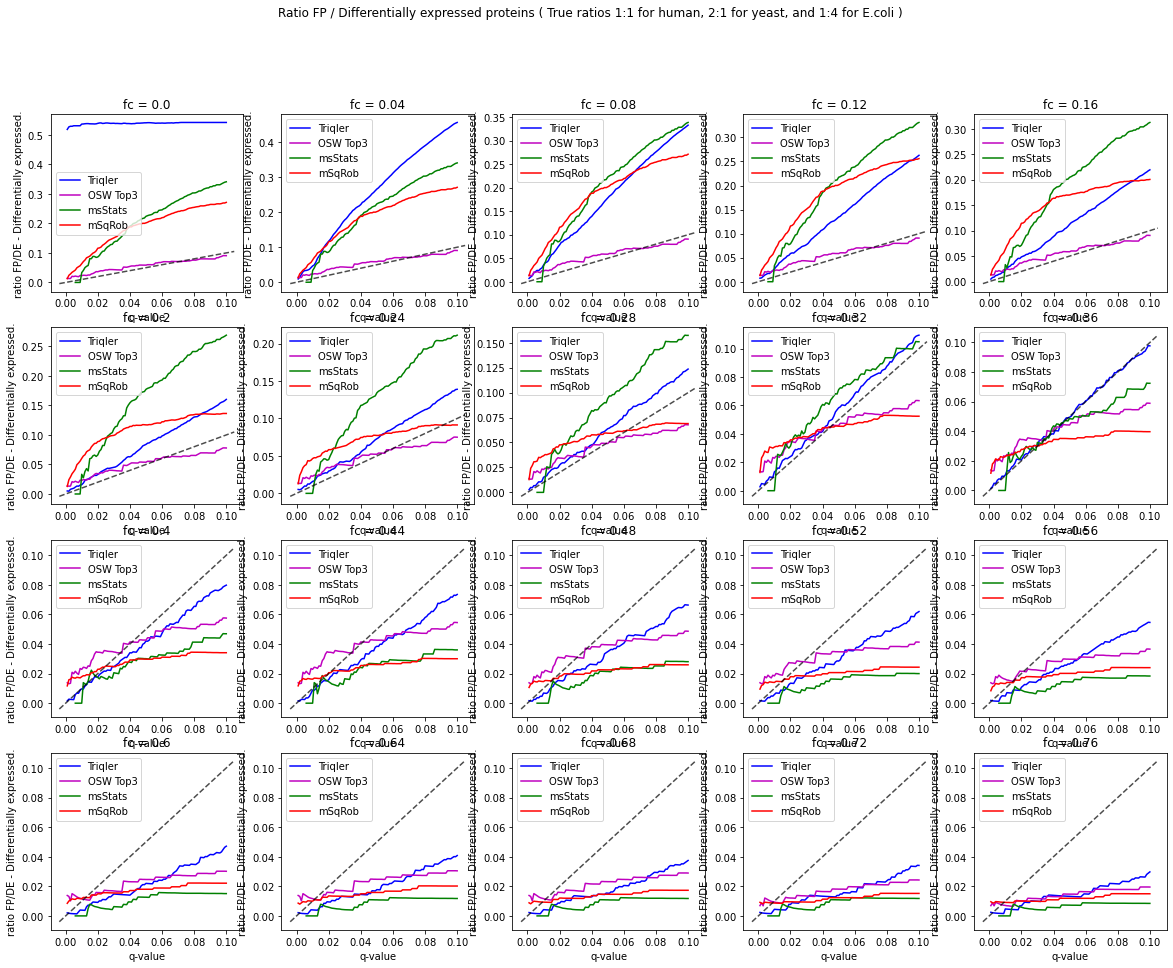

In [319]:
plot_ratio_FP_DE(specie = "all", fcs = fcs)

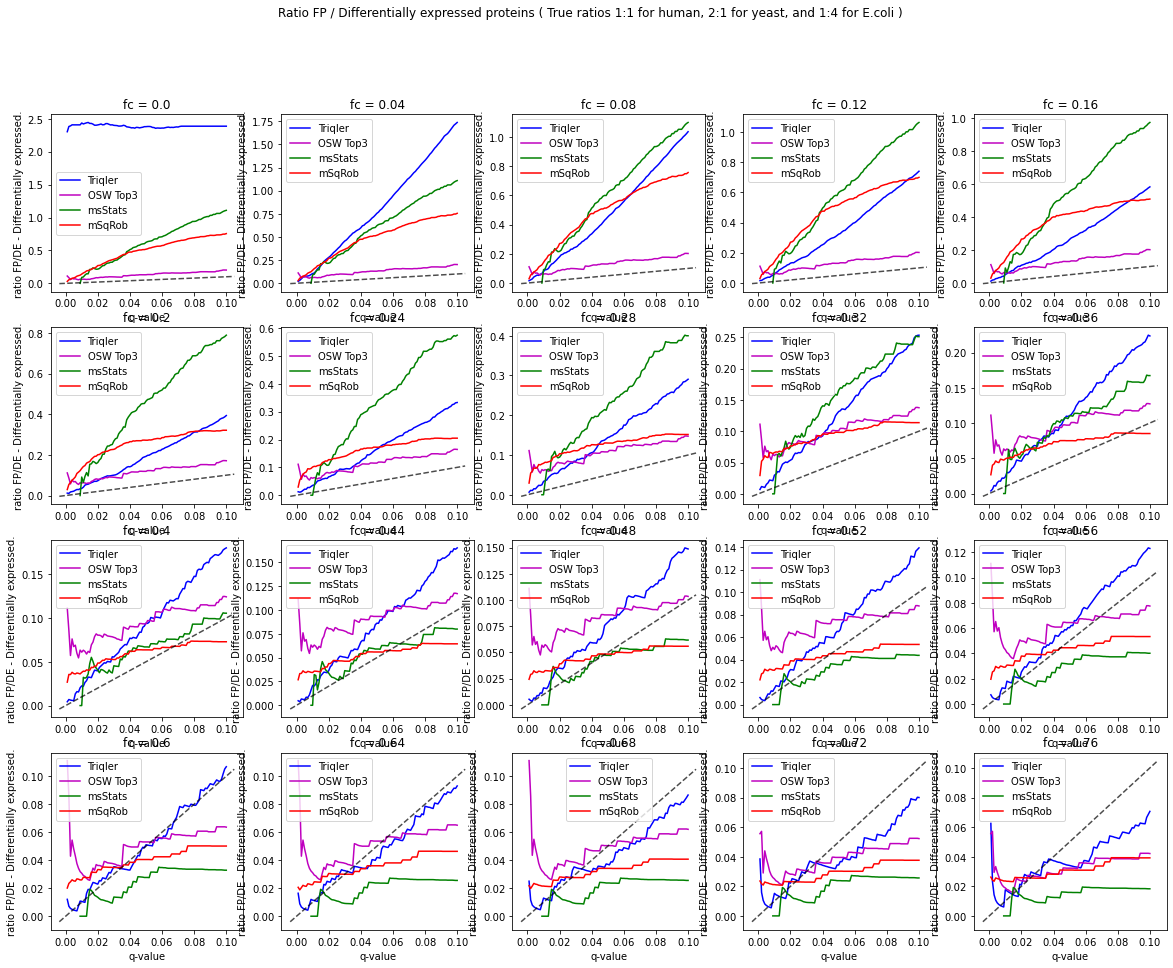

In [320]:
plot_ratio_FP_DE(specie = "YEAST", fcs = fcs)

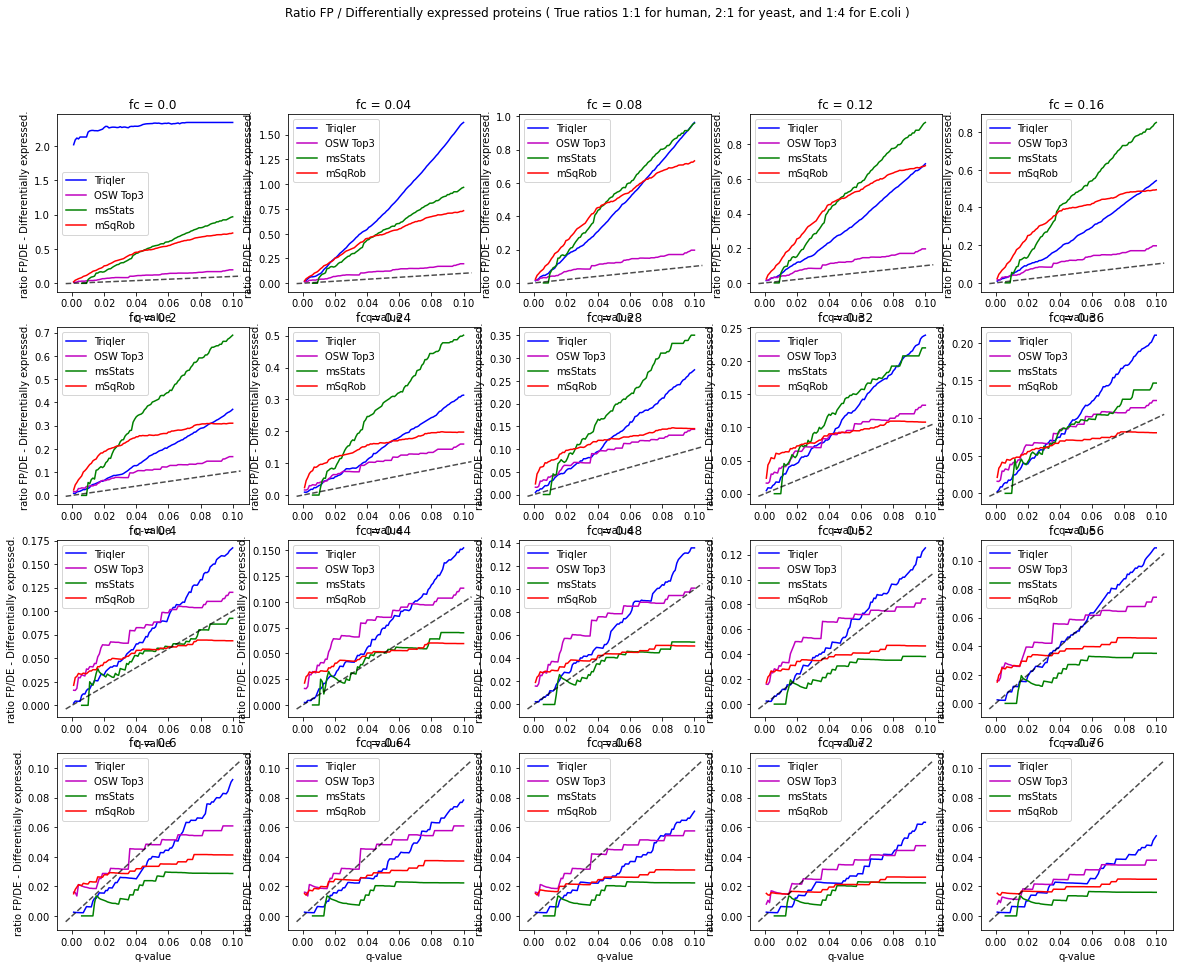

In [321]:
plot_ratio_FP_DE(specie = "ECOLI", fcs = fcs)

# DE YEAST or ECOLI as a function of DE HUMAN

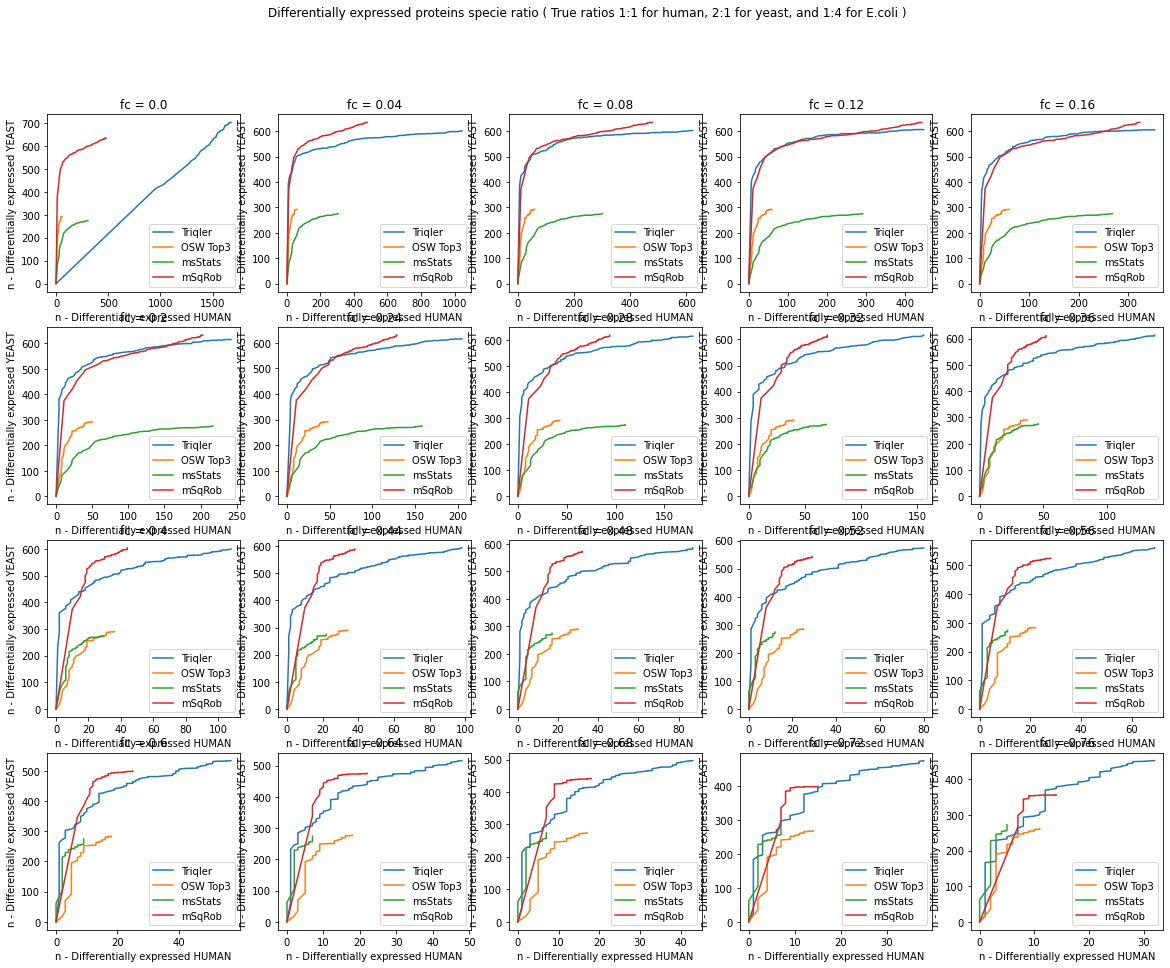

In [322]:
#plot_de_specie_xy(specie_x = "HUMAN")
plot_de_specie_xy(specie_x = "HUMAN",specie_y = "YEAST", fcs = fcs)


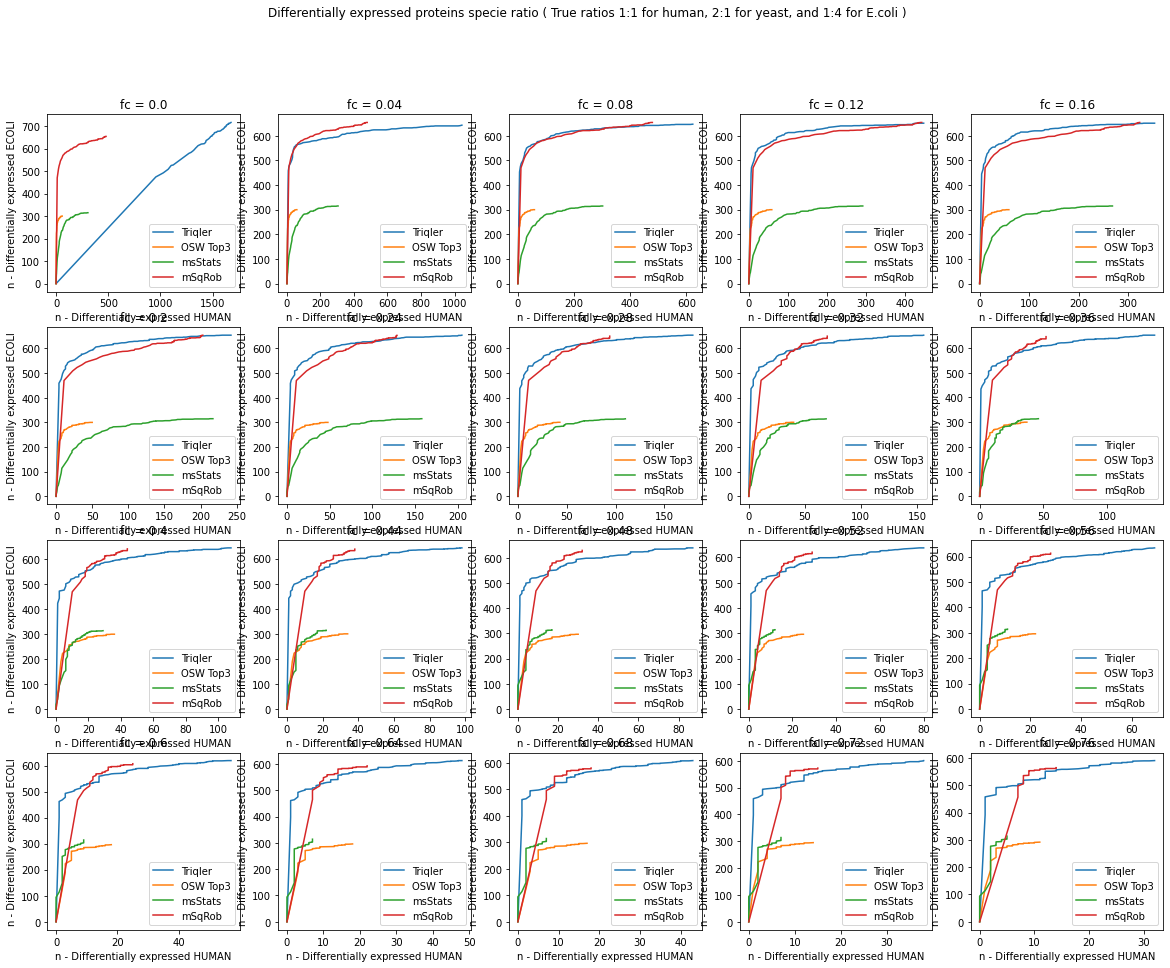

In [323]:
plot_de_specie_xy(specie_x = "HUMAN",specie_y = "ECOLI", fcs = fcs)

# Distributions of log2FC

### Note that the log2FC are not q-value tresholded

In [324]:
import seaborn as sns

In [325]:
df_final

1          2         p         q  log2(A,B)
specie ProteinName                                                      
ECOLI  P00350_ECOLI  11.839839  13.208182  0.000036  0.000647  -1.368343
       P00363_ECOLI  10.677972  12.236316  0.000268  0.001861  -1.558344
       P00393_ECOLI   7.603437  10.182940       NaN  1.000000  -2.579503
       P00490_ECOLI   9.981754  11.162163       NaN  1.000000  -1.180409
       P00550_ECOLI   9.289985  11.517450  0.000660  0.003235  -2.227466
...                        ...        ...       ...       ...        ...
YEAST  Q12522_YEAST  12.228178  11.251686       NaN  1.000000   0.976493
       Q12746_YEAST   9.154379   8.709967       NaN  1.000000   0.444412
       Q96VH4_YEAST  10.638719   9.504165  0.000987  0.004360   1.134555
       Q99258_YEAST   9.628142   8.063853       NaN  1.000000   1.564289
       Q99383_YEAST  10.705768   9.851571  0.013350  0.035128   0.854197

[2029 rows x 5 columns]

# Top3 log2FC distribution

Text(0.5, 0.98, 'Top3 log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

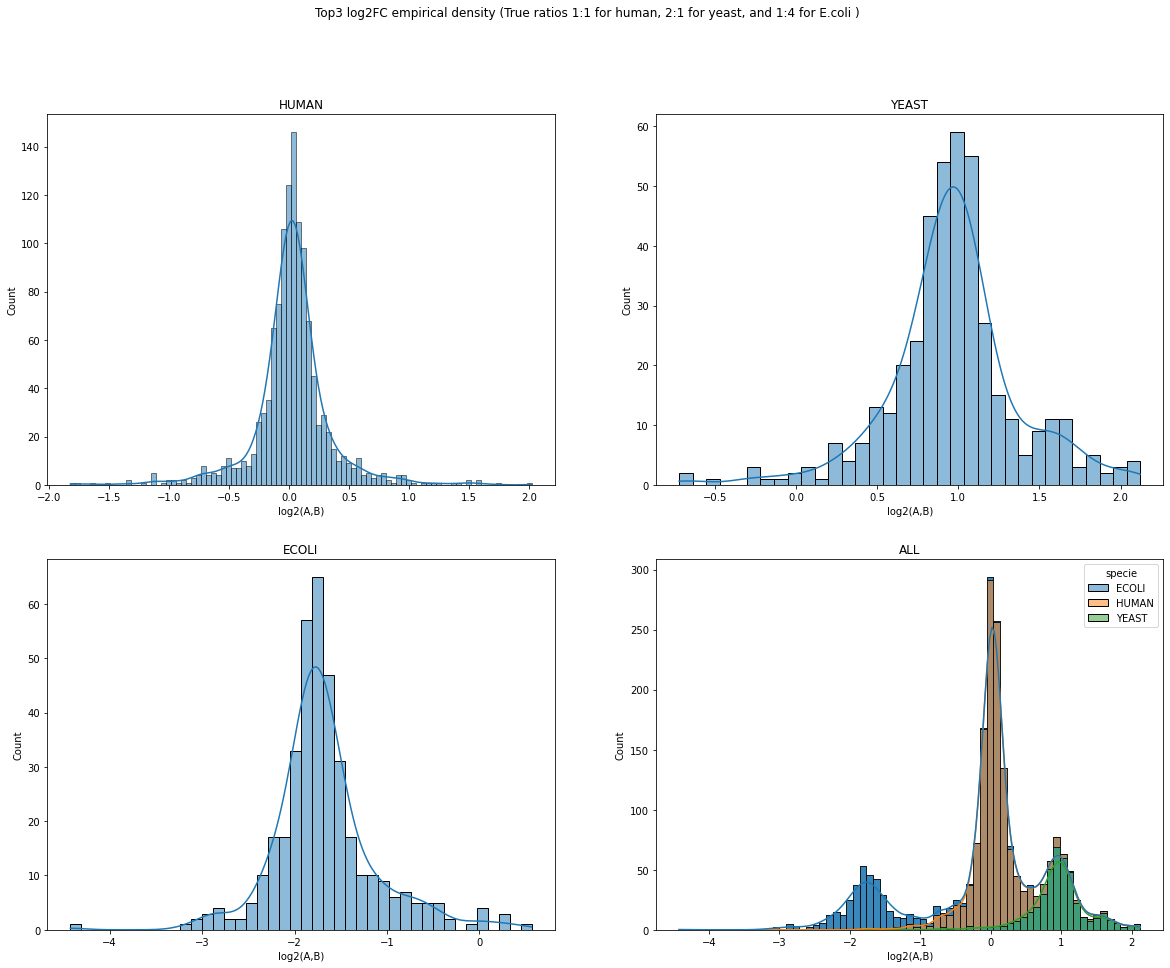

In [326]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
sns.histplot(df_final[df_final.index.get_level_values("specie")=="HUMAN"]["log2(A,B)"], kde = True, ax = axs[0,0])
axs[0,0].set_title("HUMAN")  
sns.histplot(df_final[df_final.index.get_level_values("specie")=="YEAST"]["log2(A,B)"], kde = True, ax = axs[0,1])
axs[0,1].set_title("YEAST")  
sns.histplot(df_final[df_final.index.get_level_values("specie")=="ECOLI"]["log2(A,B)"], kde = True, ax = axs[1,0])
axs[1,0].set_title("ECOLI")
sns.histplot(df_final["log2(A,B)"], kde = False, ax = axs[1,1])
axs[1,1].set_title("ALL")
sns.histplot(data=df_final, x="log2(A,B)", hue="specie", multiple="stack", kde = True)
fig.suptitle('Top3 log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )') 


# Triqler - log2FC distribution

Text(0.5, 0.98, 'Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

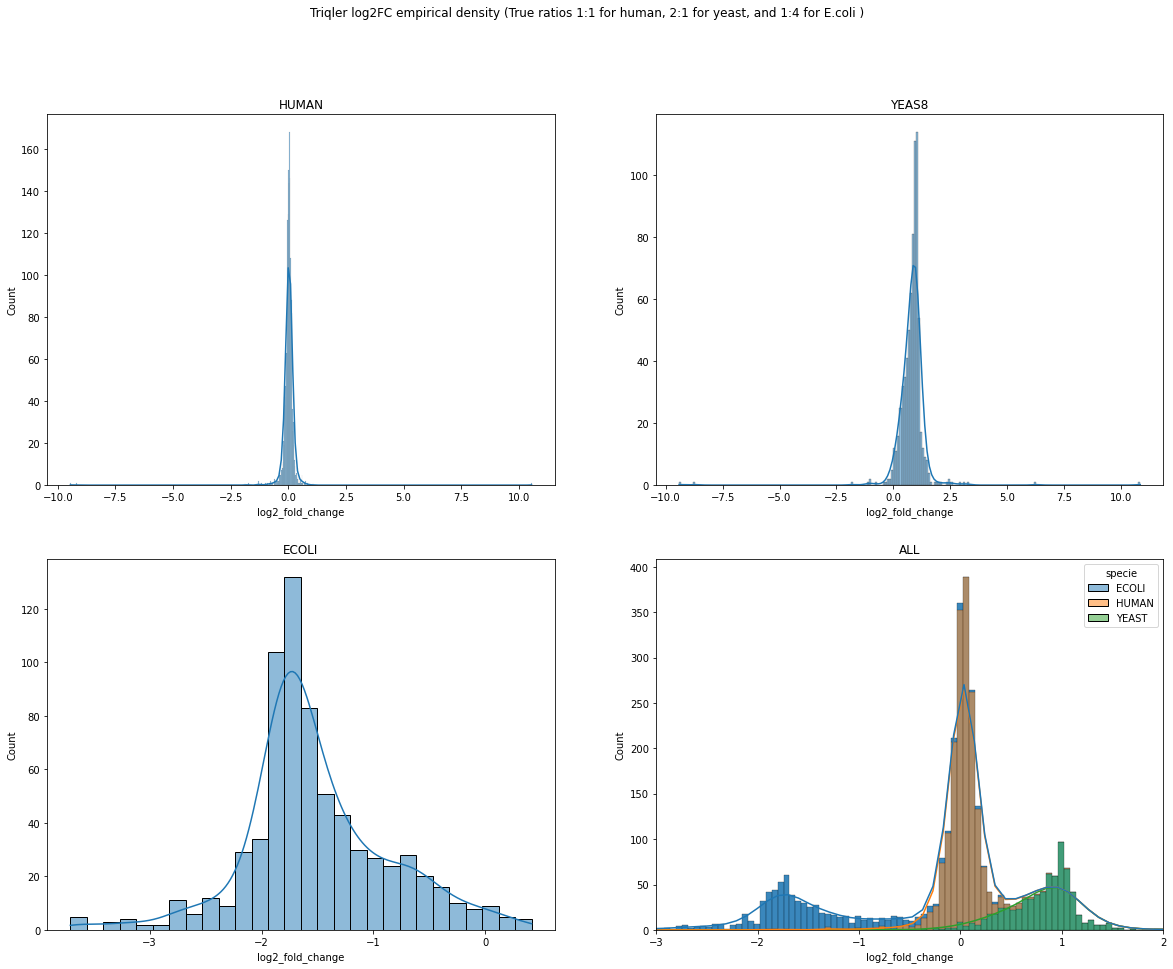

In [327]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")
q_val = 1
file = "fc_0.60"
df_triq = parse_triqler(file)
df_triq["decoy"] = df_triq.protein.map(decoy_mapper)
df_triq = df_triq[df_triq.decoy == False] # remove decoy proteins.
df_triq = df_triq[df_triq.q_value < q_val]
df_triq["specie"] = df_triq.protein.map(specie_mapper)

fig, axs = plt.subplots(2, 2, figsize=(20,15))
sns.histplot(df_triq[df_triq.specie == "HUMAN"]["log2_fold_change"], kde = True, ax = axs[0,0])
axs[0,0].set_title("HUMAN")  
sns.histplot(df_triq[df_triq.specie == "YEAST"]["log2_fold_change"], kde = True, ax = axs[0,1])
axs[0,1].set_title("YEAS8")  
sns.histplot(df_triq[df_triq.specie == "ECOLI"]["log2_fold_change"], kde = True, ax = axs[1,0])
axs[1,0].set_title("ECOLI")
sns.histplot(df_triq["log2_fold_change"], kde = False, ax = axs[1,1])
sns.histplot(data=df_triq, x="log2_fold_change", hue="specie", multiple="stack", kde = True)
axs[1,1].set_xlim([-3, 2])

axs[1,1].set_title("ALL")
fig.suptitle('Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

# msStats - log2FC distribution

Text(0.5, 0.98, 'msStats log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

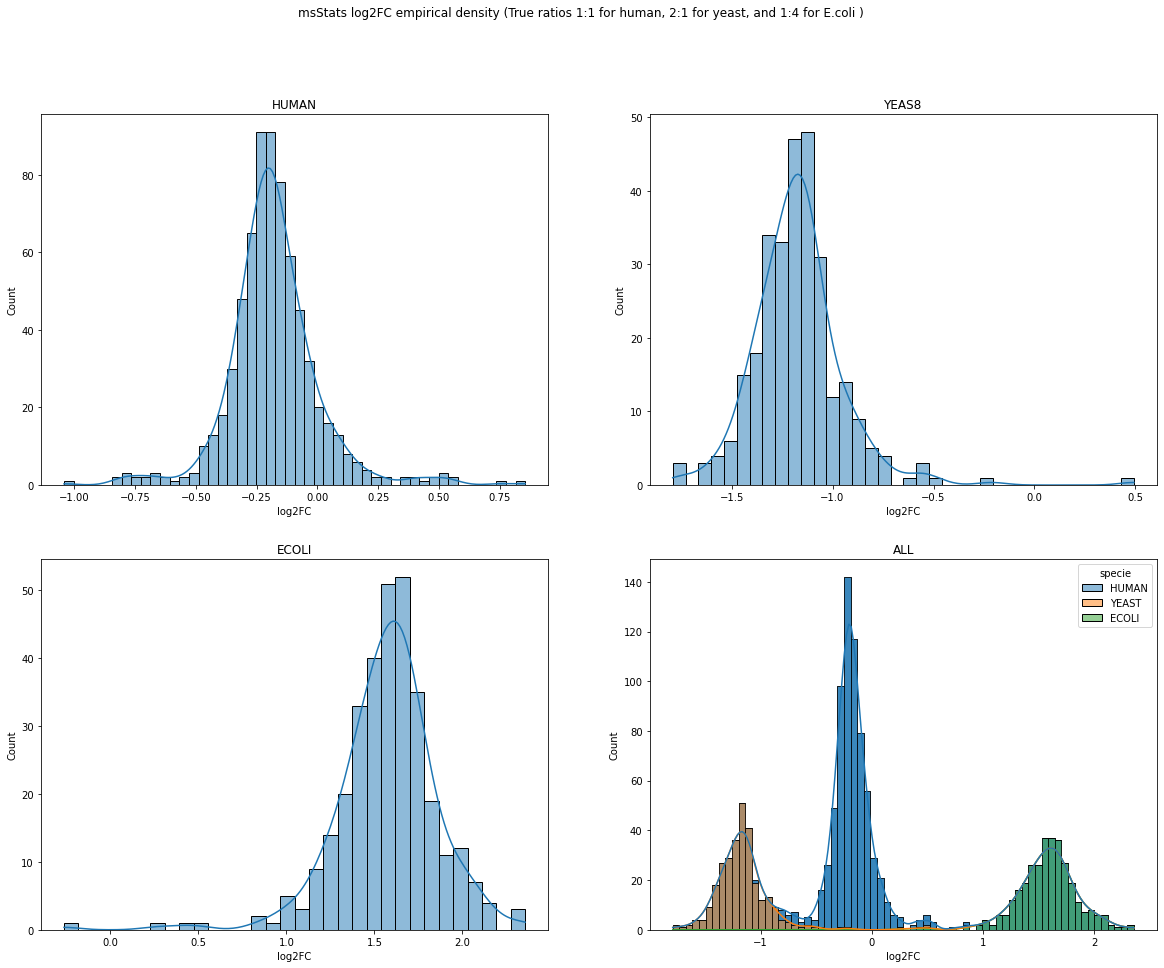

In [328]:
ms["specie"] = ms.Protein.map(specie_mapper)
fig, axs = plt.subplots(2, 2, figsize=(20,15))
sns.histplot(ms[ms.specie == "HUMAN"].log2FC, kde = True, ax = axs[0,0])
axs[0,0].set_title("HUMAN")  
sns.histplot(ms[ms.specie == "YEAST"].log2FC, kde = True, ax = axs[0,1])
axs[0,1].set_title("YEAS8")  
sns.histplot(ms[ms.specie == "ECOLI"].log2FC, kde = True, ax = axs[1,0])
axs[1,0].set_title("ECOLI")
sns.histplot(ms.log2FC, kde = False, ax = axs[1,1], bins = 70)
sns.histplot(data=ms, x="log2FC", hue="specie", multiple="stack", bins = 70, kde = True)

axs[1,1].set_title("ALL")
fig.suptitle('msStats log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')


# msqrobsum

Text(0.5, 0.98, 'msqrobsum log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

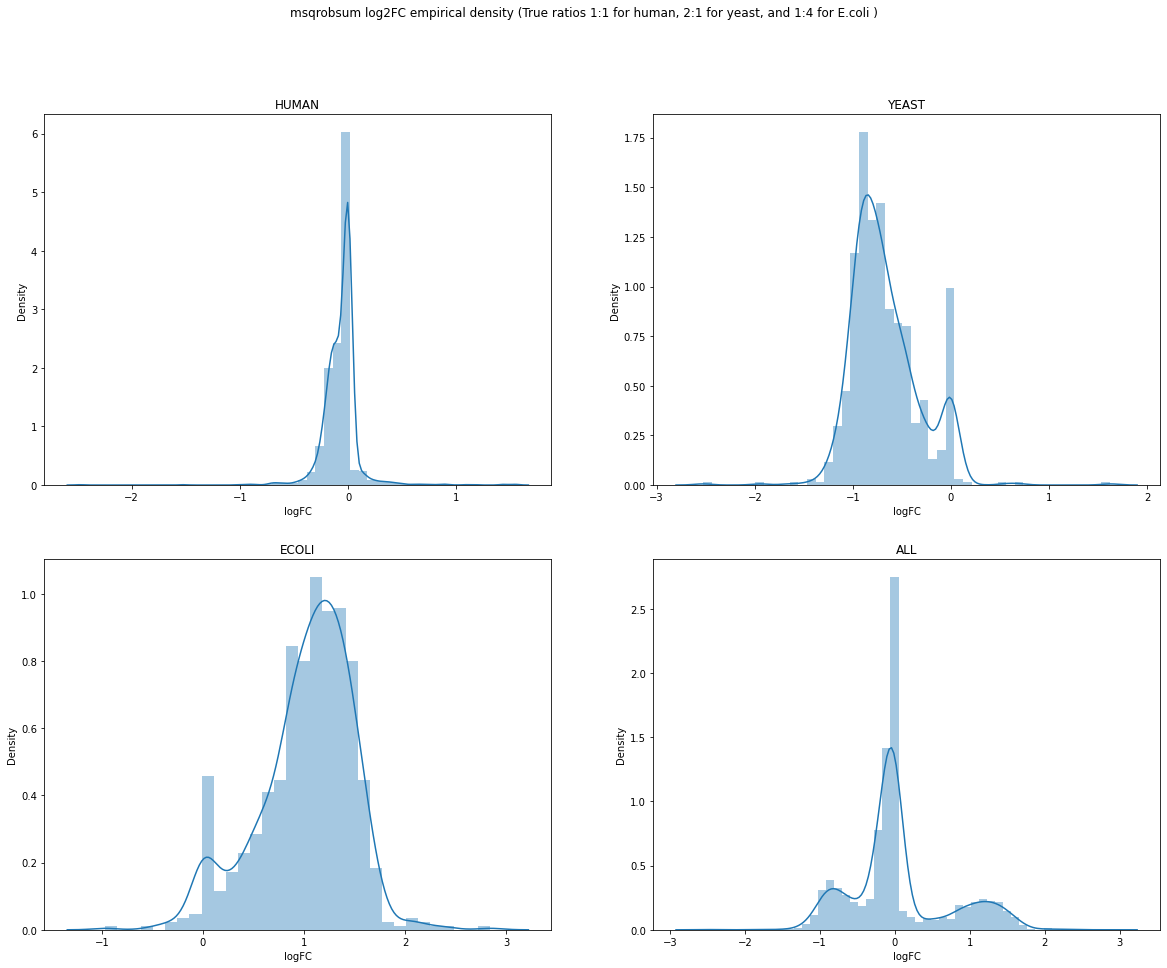

In [329]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
sns.distplot(msqrob[msqrob.specie == "HUMAN"].logFC, hist = True, ax = axs[0,0])
axs[0,0].set_title("HUMAN")  
sns.distplot(msqrob[msqrob.specie == "YEAST"].logFC, hist = True, ax = axs[0,1])
axs[0,1].set_title("YEAST")  
sns.distplot(msqrob[msqrob.specie == "ECOLI"].logFC, hist = True, ax = axs[1,0])
axs[1,0].set_title("ECOLI")
sns.distplot(msqrob.logFC, hist = True, ax = axs[1,1])
#sns.distplot(data=msqrob, x="logFC", hue="specie", multiple="stack", hist = True)
axs[1,1].set_title("ALL")
fig.suptitle('msqrobsum log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')


In [330]:
# sns.histplot(msqrob[msqrob.specie == "HUMAN"].logFC, kde = True), does not work with the histplot
# ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

# 2021-05-27 Scaled calibration plots

In [331]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")
# set fcs
fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    ecoli_scaling_factor = []
    yeast_scaling_factor = []
    human_scaling_factor = []
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        ecoli_factor = (df_triq["specie"] == "ECOLI").sum()/(df_triq["specie"] == "HUMAN").sum()
        yeast_factor = (df_triq["specie"] == "YEAST").sum()/(df_triq["specie"] == "HUMAN").sum()
        human_factor = (df_triq["specie"] == "HUMAN").sum()/(df_triq["specie"] == "HUMAN").sum()
        df_triq = df_triq[df_triq.q_value < q_val]
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        ecoli_scaling_factor.append(ecoli_factor) #Should be same for all values because we want the full length of protein list
        yeast_scaling_factor.append(yeast_factor) #Should be same for all values because we want the full length of protein list
        human_scaling_factor.append(human_factor)
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec,
                               human_scaling_factor, yeast_scaling_factor, ecoli_scaling_factor]).T, index = fc_tresh, columns = ["HUMAN", "YEAS8", "ECOLI", "HUMAN_factor", "YEAS8_factor", "ECOLI_factor"])
    return df

def map_decoy(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI", "HUMAN_factor", "YEAST_factor", "ECOLI_factor"])
        res.append(df_res)
    return res

res = get_DE_for_fcs( fcs = fcs)


In [332]:

def get_top3_factor(specie):
    return len(df_final[df_final.index.get_level_values("specie") == specie])/len(df_final[df_final.index.get_level_values("specie") == "HUMAN"])

#triqler_factor() # contained in res from get_DE_for_fcs - triqler read-in funciton

def get_msstat_factor(specie):
    return len(ms[ms["specie"] == specie]) / len(ms[ms["specie"] == "HUMAN"])  

def get_msqrob_factor(specie):
    return len(msqrob[msqrob["specie"] == specie]) / len(msqrob[msqrob["specie"] == "HUMAN"])

#FP ratio
def plot_ratio_FP_DE_scale(fcs,specie):
    fig, axs = plt.subplots(2, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(10):
        fc = fcs[i]
        
        top3_factor = get_top3_factor(specie)
        msstat_factor = get_msstat_factor(specie)
        msqrob_factor = get_msqrob_factor(specie)
        
        
        if specie == "all":
            top3_factor =  get_top3_factor("HUMAN") + get_top3_factor("ECOLI") + get_top3_factor("YEAST")
            msstat_factor = get_msstat_factor("HUMAN") + get_msstat_factor("ECOLI") + get_msstat_factor("YEAST")
            msqrob_factor = get_msqrob_factor("HUMAN") + get_msqrob_factor("ECOLI") + get_msqrob_factor("YEAST")
            
            
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final, fc_treshold = fc)) * (top3_factor)
            df_triq = (res[i]["HUMAN"] / 
                       res[i].sum(axis=1)) * (res[i]["HUMAN_factor"]+res[i]["ECOLI_factor"] +res[i]["YEAST_factor"] )
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms, fc = fc)) * msstat_factor
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob, fc = fc)) * msqrob_factor        
        else:
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)) * top3_factor
            df_triq = (res[i]["HUMAN"] / 
                       res[i][specie]) * res[i][specie + "_factor"]
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms[ms.specie == specie], fc = fc)) * msstat_factor
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)) * msqrob_factor   

        df_triq.plot(ax = axs[row, col], style = "b") # triqler data plot
        axs[row, col].plot(df.index, df.DE, "m") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")
        
        def abline(slope, intercept, row, col):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axs[row,col].get_xlim())
            y_vals = intercept + slope * x_vals
            axs[row,col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
        abline(1,0,row,col)
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


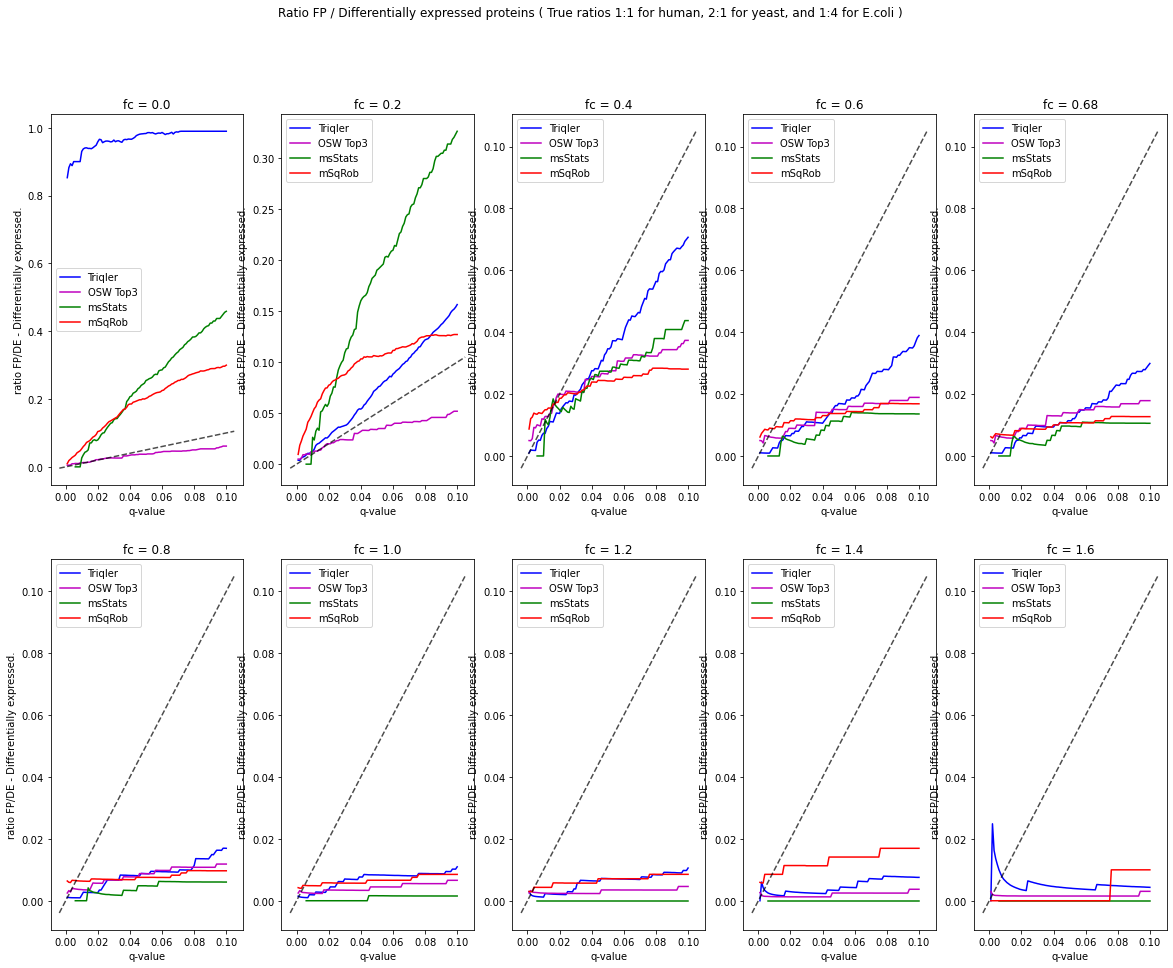

In [333]:
plot_ratio_FP_DE_scale(fcs, "ECOLI")

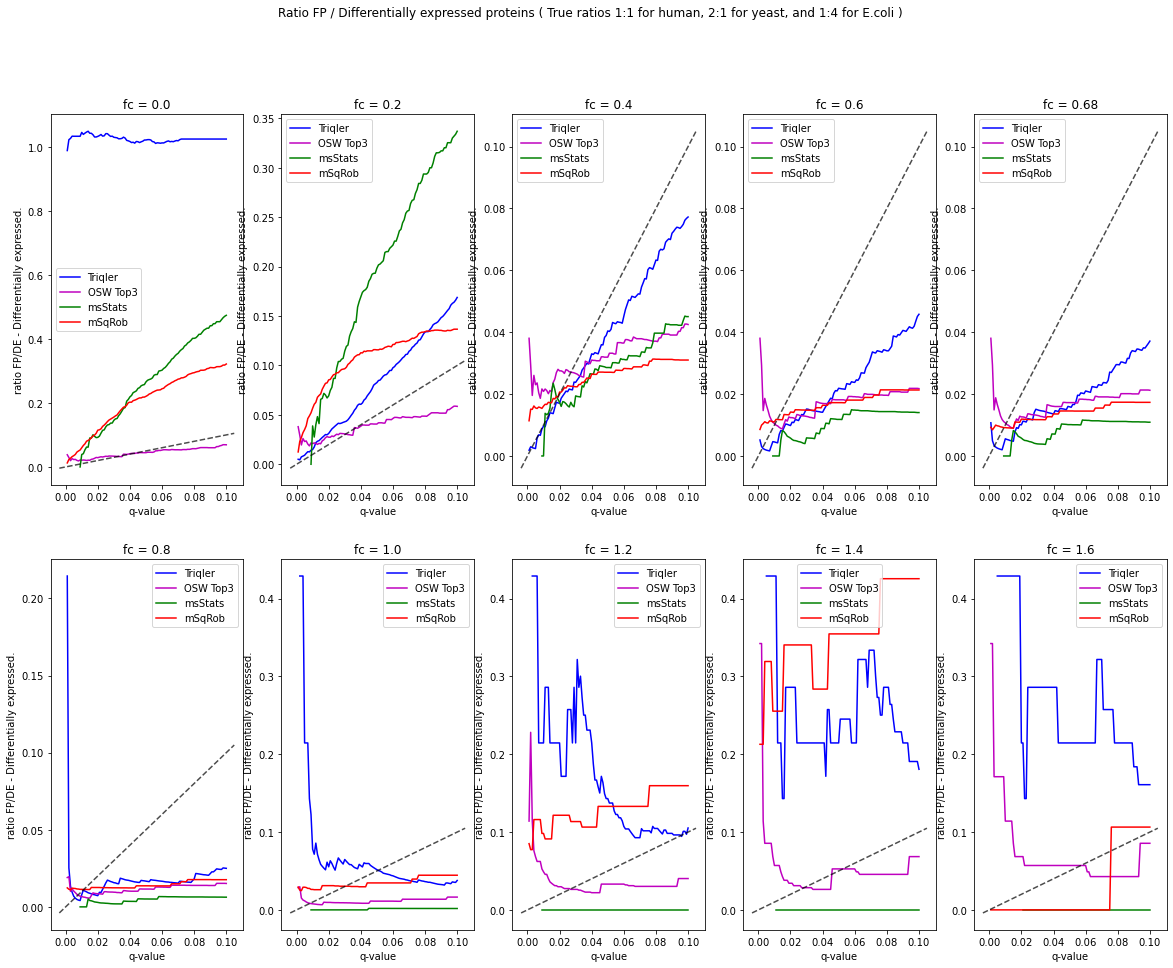

In [334]:

plot_ratio_FP_DE_scale(fcs, "YEAST")

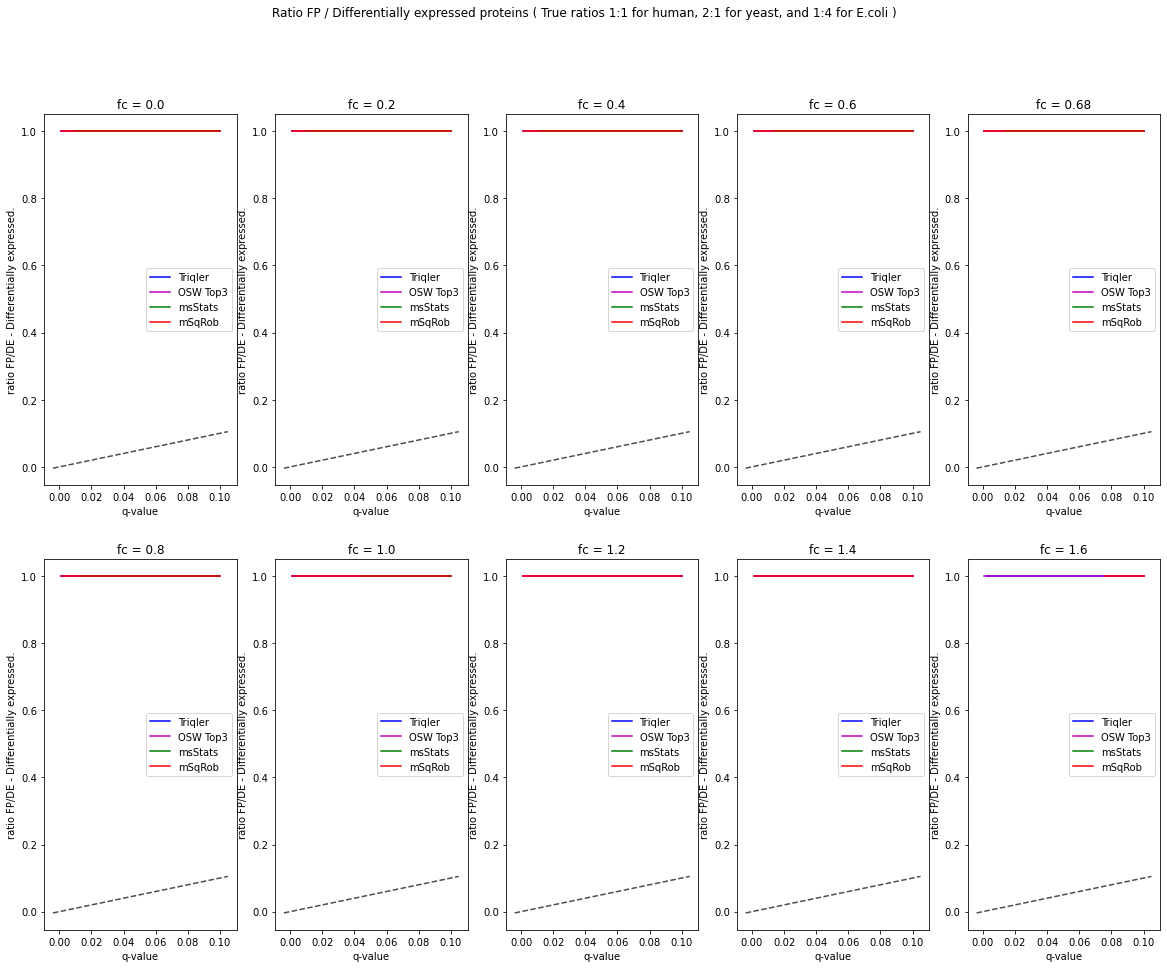

In [335]:
plot_ratio_FP_DE_scale(fcs, "HUMAN")

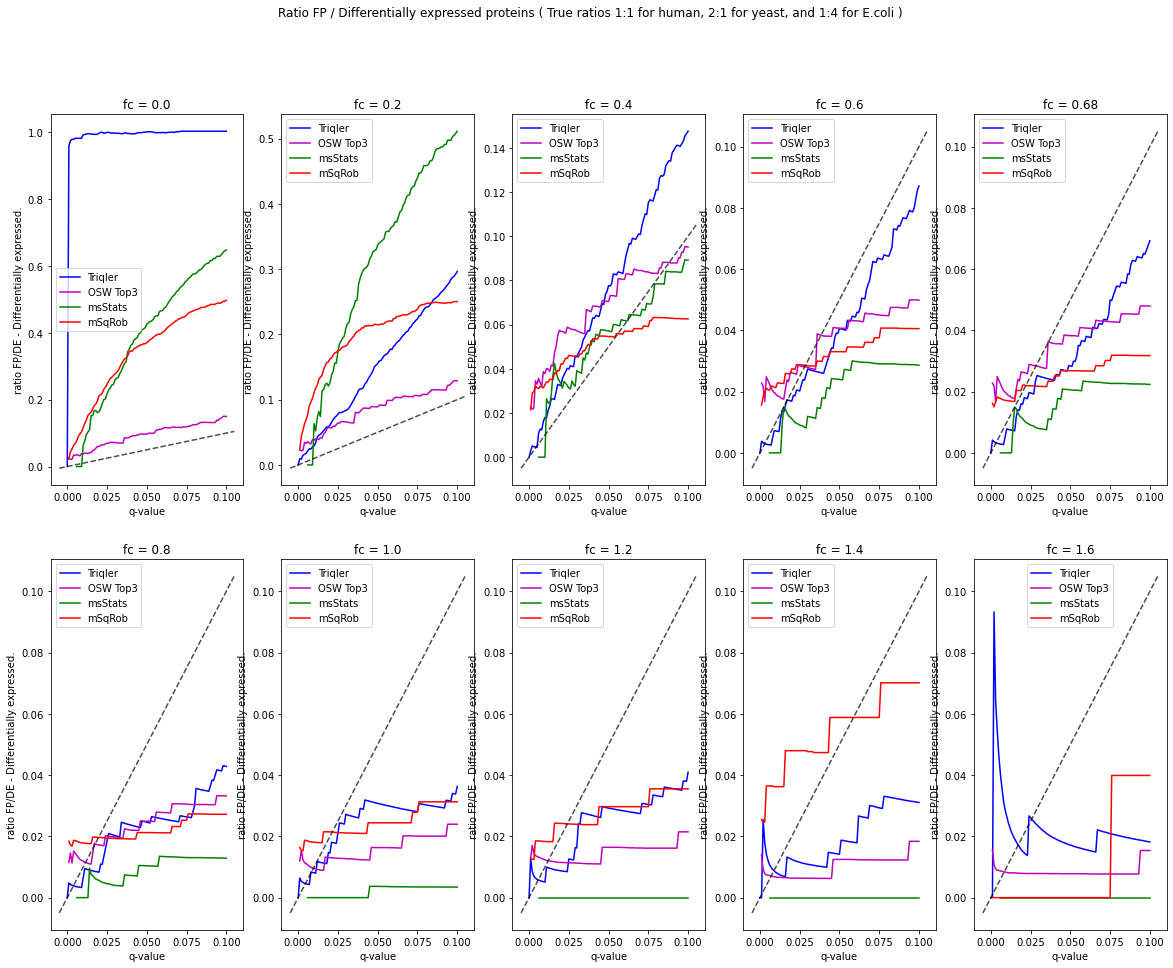

In [336]:
plot_ratio_FP_DE_scale(fcs, "all")

In [337]:
res[0]

HUMAN  YEAST  ECOLI  HUMAN_factor  YEAST_factor  ECOLI_factor
0.000     0.0    0.0    0.0           1.0      0.429084      0.422801
0.001   956.0  415.0  474.0           1.0      0.429084      0.422801
0.002  1027.0  431.0  492.0           1.0      0.429084      0.422801
0.003  1074.0  449.0  508.0           1.0      0.429084      0.422801
0.004  1103.0  458.0  525.0           1.0      0.429084      0.422801
...       ...    ...    ...           ...           ...           ...
0.096  1676.0  702.0  716.0           1.0      0.429084      0.422801
0.097  1676.0  702.0  716.0           1.0      0.429084      0.422801
0.098  1676.0  702.0  716.0           1.0      0.429084      0.422801
0.099  1676.0  702.0  716.0           1.0      0.429084      0.422801
0.100  1676.0  702.0  716.0           1.0      0.429084      0.422801

[101 rows x 6 columns]

# Smaller granularity for fcs

In [338]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")
fcs =  [round(i*0.04,2) for i in range(20)]
res = get_DE_for_fcs( fcs = fcs)


In [339]:

#FP ratio
def plot_ratio_FP_DE_scale(fcs,specie):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        top3_factor = get_top3_factor(specie)
        msstat_factor = get_msstat_factor(specie)
        msqrob_factor = get_msqrob_factor(specie)
        
        
        if specie == "all":
            top3_factor =  get_top3_factor("HUMAN") + get_top3_factor("ECOLI") + get_top3_factor("YEAS8")
            msstat_factor = get_msstat_factor("HUMAN") + get_msstat_factor("ECOLI") + get_msstat_factor("YEAS8")
            msqrob_factor = get_msqrob_factor("HUMAN") + get_msqrob_factor("ECOLI") + get_msqrob_factor("YEAS8")
            
            
            df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final, fc_treshold = fc))) * (top3_factor)
            df_triq = ((res[i]["HUMAN"] / 
                       res[i].sum(axis=1))) * (res[i]["HUMAN_factor"]+res[i]["ECOLI_factor"] +res[i]["YEAS8_factor"] )
            df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms, fc = fc))) * msstat_factor
            df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob, fc = fc))) * msqrob_factor        
        else:
            df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))) * top3_factor
            df_triq = ((res[i]["HUMAN"] / 
                       res[i][specie])) * res[i][specie + "_factor"]
            df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms[ms.specie == specie], fc = fc))) * msstat_factor
            df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))) * msqrob_factor   

        df_triq.plot(ax = axs[row, col], style = "b") # triqler data plot
        axs[row, col].plot(df.index, df.DE, "m") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")
        
        def abline(slope, intercept, row, col):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axs[row,col].get_xlim())
            y_vals = intercept + slope * x_vals
            axs[row,col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
        abline(1,0,row,col)
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


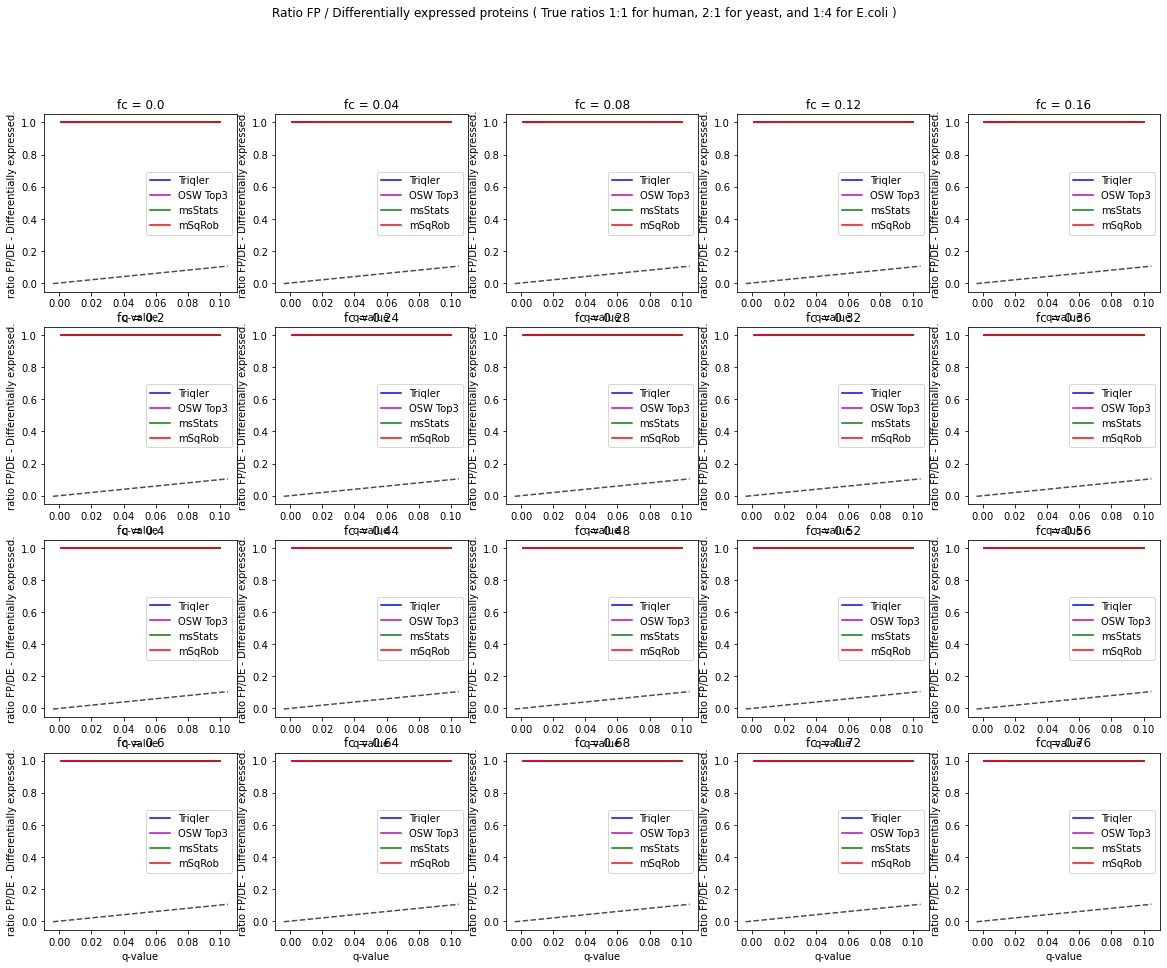

In [340]:
plot_ratio_FP_DE_scale(fcs, "HUMAN")

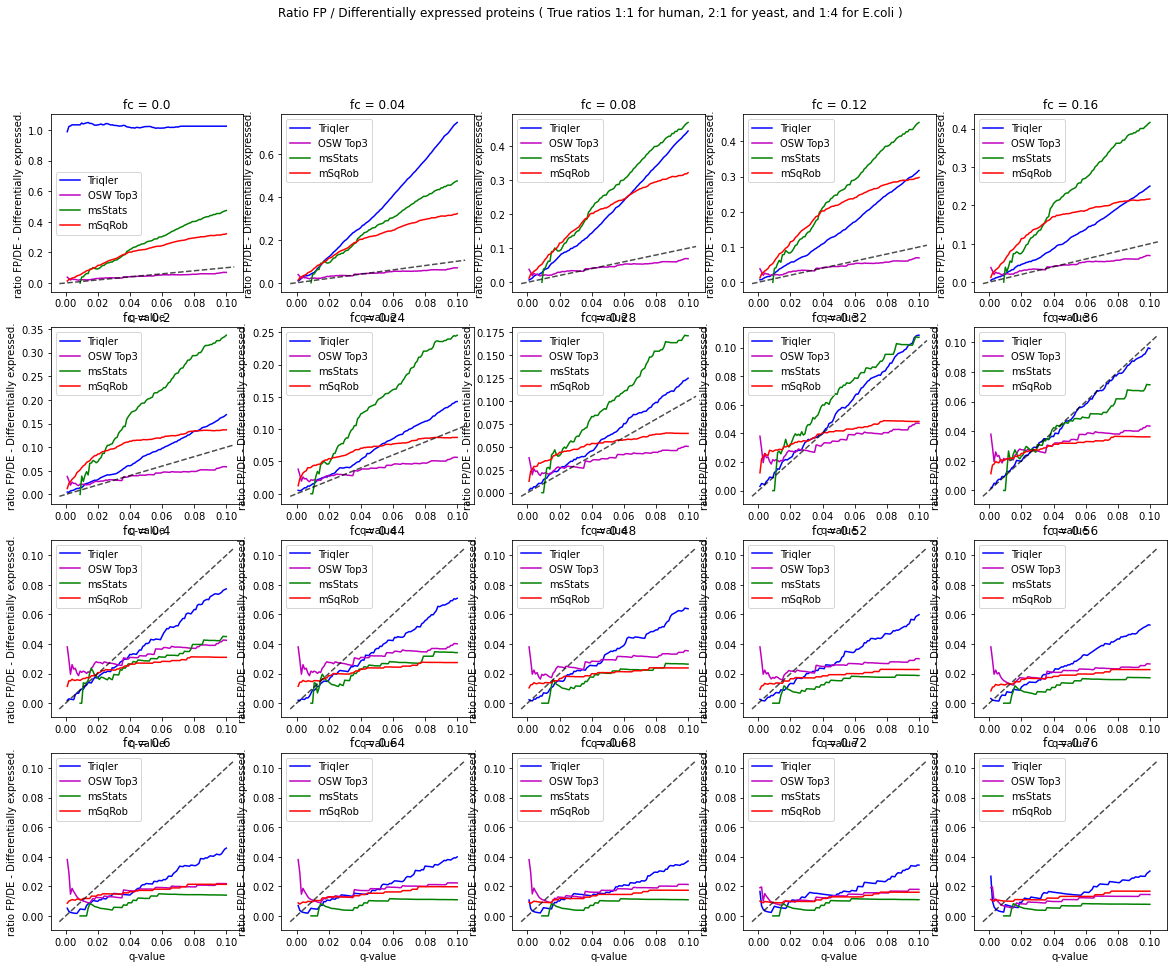

In [341]:
plot_ratio_FP_DE_scale(fcs, "YEAST")

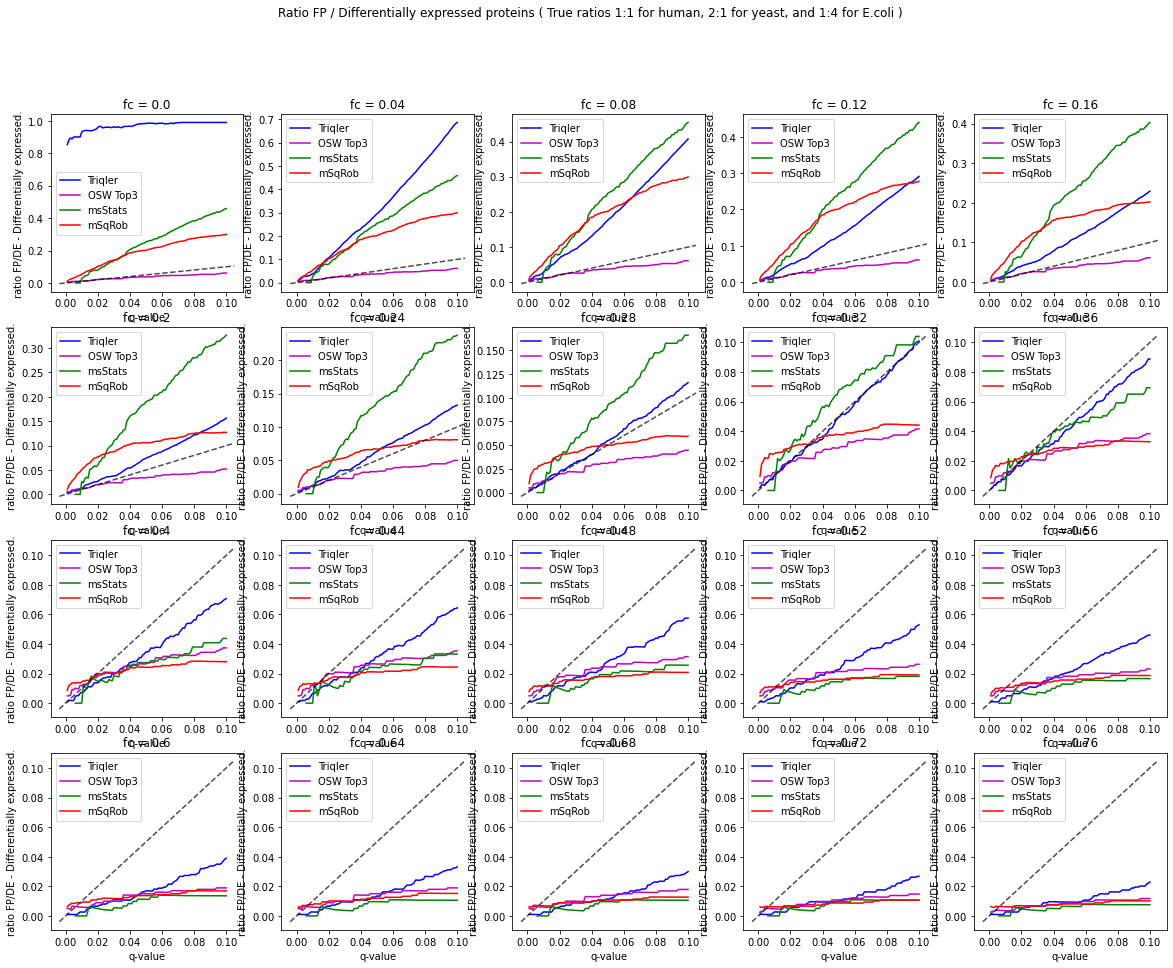

In [342]:
plot_ratio_FP_DE_scale(fcs, "ECOLI")

# Discussion

## Optimum FC

### Scaled Triqler results:

YEAS8 - 0.28 / 0.32

ECOLI - 0.28

ALL - 0.36/0.4

Scaled result seem to give the same opti for YEAS8 and ECOLI.

### Scaled other results:

Other methods seem to never be perfectly calibrated regardless of fc.

### non-scaled Triqler results:

YEAS8 - 0.36

ECOLI - 0.4

ALL - 0.24

The non-scaled results gave higher optimal fc, which is expected becuse of the ratios HUMAN 1:1, YEAS8 1:2, ECOLI 1:4. The wide log2FC distributions of triqler posterior probabilities explain the relatively low optimum FC for high true FC values.

### non-scaled other results

Other methods seem to have higher FD in most cases. At least not as well calibrated as triqler. As well as increasing fc does not seem to shift the slope of the curve or in any other way make the calibration curve fit the calibration line any better.




In [343]:
res[0]

HUMAN  YEAST  ECOLI  HUMAN_factor  YEAST_factor  ECOLI_factor
0.000     0.0    0.0    0.0           1.0      0.429084      0.422801
0.001   956.0  415.0  474.0           1.0      0.429084      0.422801
0.002  1027.0  431.0  492.0           1.0      0.429084      0.422801
0.003  1074.0  449.0  508.0           1.0      0.429084      0.422801
0.004  1103.0  458.0  525.0           1.0      0.429084      0.422801
...       ...    ...    ...           ...           ...           ...
0.096  1676.0  702.0  716.0           1.0      0.429084      0.422801
0.097  1676.0  702.0  716.0           1.0      0.429084      0.422801
0.098  1676.0  702.0  716.0           1.0      0.429084      0.422801
0.099  1676.0  702.0  716.0           1.0      0.429084      0.422801
0.100  1676.0  702.0  716.0           1.0      0.429084      0.422801

[101 rows x 6 columns]